## Importamos y definimos el directorio y la version 

In [1]:
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

directorio='G:\\Redes\\'
version=5

## Armamos la red dirigida a partir del archivo filtrado

In [3]:
N=10000000
i=0
G=nx.DiGraph()
archivo = open(directorio+'archivo_red_'+str(version)+'.txt','r',encoding='utf-8')
for line in archivo:
    i+=1
    G.add_edges_from([(line.split()[0],line.split()[1])])
    if i==N:
        break
archivo.close()
print(len(G),i)

2751733 9908260


## Añadimos el año del paper como atributo a cada nodo

In [4]:
archivo = open(directorio+'archivo_year_'+str(version)+'.txt','r',encoding='utf-8')
i=0
for line in archivo:
    i+=1
    try:
        G.node[line.split()[0]]['year']=int(line.split()[1])
    except KeyError:
        pass
    if i==N:
        break
archivo.close()

## Añadimos la revista como atributo a cada nodo

In [5]:
archivo = open(directorio+'archivo_venue_'+str(version)+'.txt','r',encoding='utf-8')
i=0
for line in archivo:
    i+=1
    venue=''
    for word in line.split()[1:]:
        venue=venue+' '+word
    try:
        G.node[line.split()[0]]['venue']=venue
    except KeyError:
        pass
    if i==N:
        break
archivo.close()

In [6]:
lista_revista={}
for node in G.nodes:
    try:
        lista_revista[G.nodes[node]['venue']]+=1
    except KeyError:
        lista_revista.update({G.nodes[node]['venue']:1})

In [7]:
orden_revistas={}
i=0
for revista in lista_revista.keys():
    i+=1
    orden_revistas.update({revista:i})

## Añadimos el campo de estudio del paper como atributo, eligiendo el más frecuente

In [8]:
archivo = open(directorio+'archivo_fos_'+str(version)+'.txt','r',encoding='utf-8')
i=0
j=0
fos = {}
for line in archivo:
    i+=1
    a=line.split('[')[1].split(']')[0].split(', ')
    for tag in range(len(a)):
            try:
                b=fos[a[tag]]
                b+=1
                fos.update({a[tag]:b})
            except:
                fos[a[tag]]=1
    if i==N:
        break
archivo.close()

In [9]:
archivo = open(directorio+'archivo_fos_'+str(version)+'.txt','r',encoding='utf-8')
i=0
j=0
for line in archivo:
    i+=1
    a=line.split('[')[1].split(']')[0].split(', ')
    freq=np.zeros(len(a))
    try:
        for k in range(len(a)):
            freq[k]=fos[a[k]]
        key=a[np.argmax(freq)]    
        G.node[line.split()[0]]['campo']=key
        j+=1
    except KeyError:
        pass
    if i==N:
        break
archivo.close()

In [10]:
lista_campo={}
for node in G.nodes:
    try:
        lista_campo[G.nodes[node]['campo']]+=1
    except KeyError:
        lista_campo.update({G.nodes[node]['campo']:1})

In [11]:
orden_campo={}
i=0
for campo in orden_campo.keys():
    i+=1
    orden_campo.update({campo:i})

## Armamos una lista de redes de cada año

In [12]:
def red_year(G):
    G_year={}
    for i in range(1850,2019):
        lista_nodos=[]
        for node in G.nodes:
            try:
                KEY=G.nodes[node]['year']<i+1
                if KEY:
                    lista_nodos.append(node)
            except KeyError:
                pass
        G_year[str(i)]=G.subgraph(lista_nodos)
    return(G_year)

In [14]:
G_year=red_year(G)

In [13]:
def frequency(Lista):
    grupo={}
    for line in range(len(Lista)):
        try:
            b=grupo[Lista[line]]
            b+=1
            grupo.update({Lista[line]:b})
        except:
            grupo[Lista[line]]=1
    return(grupo)

## Tamaño componente gigante

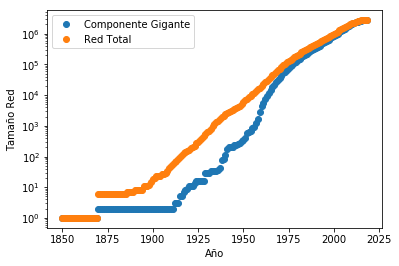

In [15]:
tamanos_gigante=[]
tamanos_red=[]
years=[]
campos=[]
for i in G_year.keys():
    campo=[]
    if len(G_year[i])>0:
        GG=G_year[i].to_undirected()
        Componente=sorted(nx.connected_components(GG), key=len, reverse=True)[0]
        Componente=GG.subgraph(Componente)
        for node in Componente.nodes:
            try:
                campo.append(G.nodes[node]['campo'])
            except KeyError:
                pass
        campos.append(Counter(campo))
        tamanos_gigante.append(len(Componente))
        tamanos_red.append(len(GG))
        years.append(int(i))

plt.semilogy(years,tamanos_gigante,'o',label='Componente Gigante')
plt.semilogy(years,tamanos_red,'o',label='Red Total')

plt.xlabel('Año');plt.ylabel('Tamaño Red');plt.legend()
plt.show()

### Dibujo red: r escala por año y tita random

In [14]:
pos={}
for node in G.nodes():
    try:
        r = (G.nodes[node]['year']-1900+0.5*np.random.normal())**5
    except KeyError:
        pass
    tita=np.random.random()*2*np.pi
    x=r*np.cos(tita)
    y=r*np.sin(tita)
    pos.update({node:np.array([x,y])})

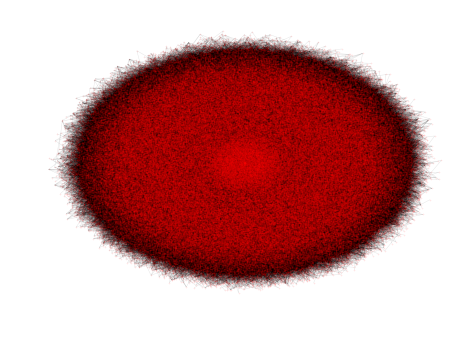

In [18]:
expo=3
options = {
'node_size': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*2,
'width': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*0.5,
'alpha': 1-np.log(len(G_year[str(i)]))/(np.log(len(G_year['2018'])))*.9,
'linewidths': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*.1}
e_alpha = 1-np.log(len(G_year[str(i)]))/(np.log(len(G_year['2018'])))*.75


nx.draw(Componente,pos=pos, node_color='red',with_labels=False, **options)

## Dibujo red: r escala por año y tita promedio de vecinos

In [ ]:
for node in G.nodes():
    try:
        r = (G.nodes[node]['year']-1900+0.5*np.random.normal())**5
    except KeyError:
        pass
    try:
        i=0
        vecinos = [vec for vec in G.neighbors(node)]
        if len(vecinos)>0:
            titas=np.zeros(len(vecinos))
            for vec in vecinos:
                x=pos[vec][0]
                y=pos[vec][1]
                if x>0 and y>=0:
                    titas[i]=np.arctan(y/x)
                elif x==0 and y>0:
                    titas[i]=np.pi*0.5
                elif x<0:
                    titas[i]=np.arctan(y/x)+np.pi
                elif x==0 and y<0:
                    titas[i]=np.pi*1.5
                else:
                    titas[i]=np.arctan(y/x)+2*np.pi
                i+=1
            xs=np.mean(np.cos(titas))
            ys=np.mean(np.sin(titas))
            if xs>0 and ys>=0:
                tita=np.arctan(y/x)
            elif xs==0 and ys>0:
                tita=np.pi*0.5
            elif xs<0:
                tita=np.arctan(y/x)+np.pi
            elif xs==0 and ys<0:
                tita=np.pi*1.5
            else:
                tita=np.arctan(y/x)+2*np.pi
        else:
            tita=np.random.random()*2*np.pi
    except KeyError:
        tita=np.random.random()*2*np.pi
    x=r*np.cos(tita)
    y=r*np.sin(tita)
    pos.update({node:np.array([x,y])})

## Dibujo red: r escala por año y tita con revista

In [17]:
pos={}
for node in G.nodes():
    try:
        r = (G.nodes[node]['year']-1900+0.5*np.random.normal())**5
    except KeyError:
        pass
    try:
        tita=((orden_revistas[G.nodes[node]['venue']]+np.random.normal()/2)/len(lista_revista))**(0.25)*2*np.pi
    except KeyError:
        tita=np.random.random()*2*np.pi
    x=r*np.cos(tita)
    y=r*np.sin(tita)
    pos.update({node:np.array([x,y])})

C:\Users\Usuario\Anaconda3\lib\site-packages\numpy\core\numeric.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Usuario\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


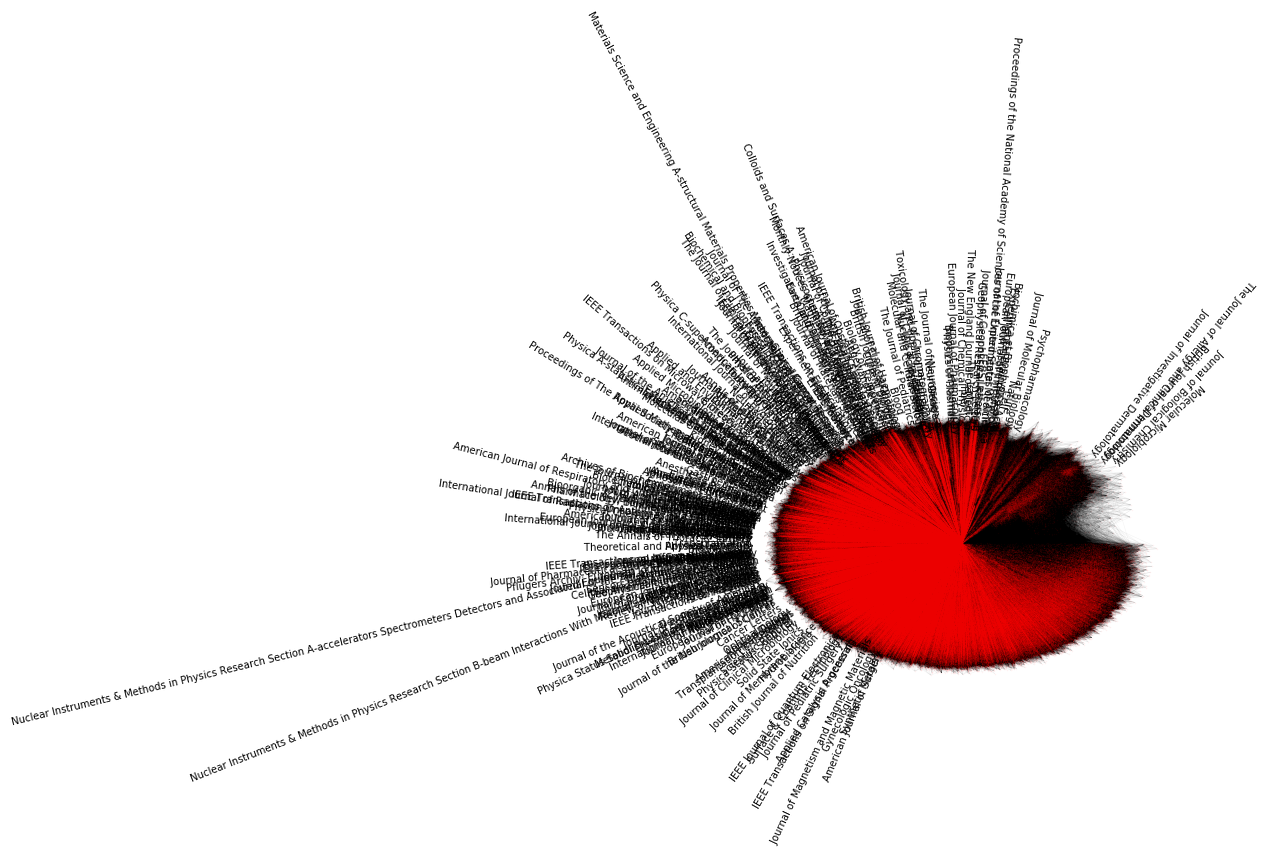

In [21]:
expo=4
options = {
    'node_size': (np.log(len(G_year['2018']))/np.log(len(G_year['2018'])))**expo*2,
    'width': (np.log(len(G_year['2018']))/np.log(len(G_year['2018'])))**expo*0.5,
    'alpha': 1-np.log(len(G_year[str(i)]))/(np.log(len(G_year['2018'])))*.95,
    'linewidths': (np.log(len(G_year['2018']))/np.log(len(G_year['2018'])))**expo*.1}
nx.draw(Componente,pos=pos, node_color='red',with_labels=False, **options)
for revista in orden_revistas.keys():
    if lista_revista[revista]>len(lista_revista)*10**-1:
        tita=(orden_revistas[revista]/len(lista_revista))**(0.25)*2*np.pi
        r=(2018-1900+2+len(revista)/4)**5
        x=r*np.cos(tita)
        y=r*np.sin(tita)
        plt.text(x,y, revista, ha="center", va="center", rotation=tita/(2*np.pi)*360+180,size=10)
plt.show()

In [25]:
def edges_interdisciplinarios(G):
    for i in G.edges():
        if G.node[i[0]]['campo']!=G.node[i[1]]['campo']:
            nx.set_edge_attributes(G, {i:{'inter':0}}, name=None)
        else:
            nx.set_edge_attributes(G, {i:{'inter':1}}, name=None)

In [26]:
G_year=red_year(Componente)
edges_interdisciplinarios(Componente)

In [27]:
import matplotlib.cm as cmx
import imageio
import random
def graficar_red_options(G,G_year,atributo,ancho,pos,lims,year_year,options,e_alpha):
    
    Componente=G.copy()
    campos_list=[]
    val_map = {}
    val_map_year = {}
    campos_list_year=[]
    e_color=[]
    for edge in G_year.edges():
        if Componente.edges[edge]['inter']==0:
            e_color.append([0,0,0,e_alpha])
        else:
            e_color.append([1,1,1,e_alpha])
    ## Generas una lista de atributo de cada nodo
    for paper in Componente:
        campos_list.append(Componente.node[paper][atributo])
        val_map.update({paper: Componente.node[paper][atributo]})

    for paper in G_year:
        campos_list_year.append(G_year.node[paper][atributo])
        val_map_year.update({paper: G_year.node[paper][atributo]})
    
    grupo={}
    
    x={}
    sorted_by_value = []
    
    ## Asignamos los colores para cada valor de atributo, distinguiendo el año de cualquier otro atributo
    if atributo == 'year':
        y={}
        x=frequency(campos_list)
        
        for line in x.keys():
            y[line]=line
        sorted_by_value = sorted(y.items(), key=lambda kv: kv[1],reverse=True)
    else:   
        x=frequency(campos_list)
        sorted_by_value = sorted(x.items(), key=lambda kv: kv[1],reverse=True)
    
    random.seed(100)
    random.shuffle(sorted_by_value)
    
    cmap =[]
    cmap = cmx.Set1(np.linspace(0.0, 1.0, len(sorted_by_value)))
 
    ## A cada valor de atributo se le asigna un determinado color
    conversion={}
    for i in range(len(sorted_by_value)):
        conversion.update({sorted_by_value[i][0]: cmap[i]})
  

    ## Asigna un color a cada uno de los nodos de la red G_year (será el mismo para todos)
    color_map =[]  

    for paper in campos_list_year:
        color_map.append(conversion[paper])
    
    # Using a figure to use it as a parameter when calling nx.draw_networkx
    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)
    plt.fill_between(lims[0],lims[1][0],lims[1][1],color='xkcd:grey')
    for label in conversion:
        pass
#         ax.plot([ancho],[1],color=conversion[label],label=label,linestyle='',marker='.')
#         ax.legend(loc="lower right", bbox_to_anchor=(0.6,0.5))
    # Just fixed the color map

    nx.draw_networkx(G_year,pos=pos, node_color=color_map,edge_color=e_color,with_labels=False,ax=ax, **options)
    
    # Setting it to how it was looking before.                                                                                                              
    plt.axis('off')
    f.set_facecolor('w')
    plt.title(year_year)
    plt.legend(numpoints = 1)
    f.tight_layout()
    plt.xlim(lims[0])
    plt.ylim(lims[1])
    plt.savefig(directorio+'fig'+year_year+'.png')
    plt.show()

No handles with labels found to put in legend.


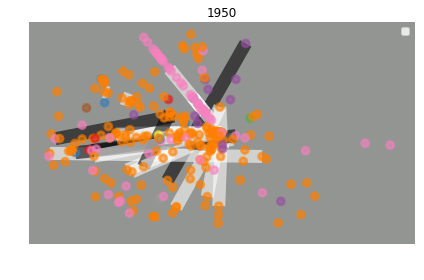

No handles with labels found to put in legend.


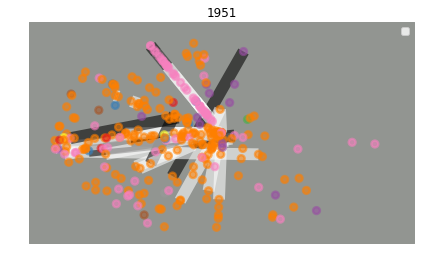

No handles with labels found to put in legend.


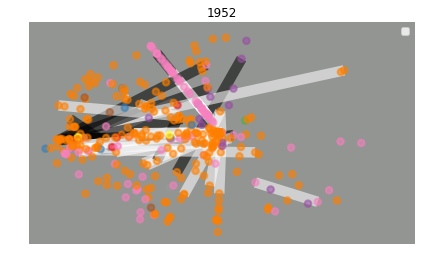

No handles with labels found to put in legend.


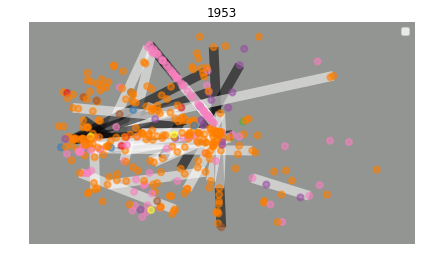

No handles with labels found to put in legend.


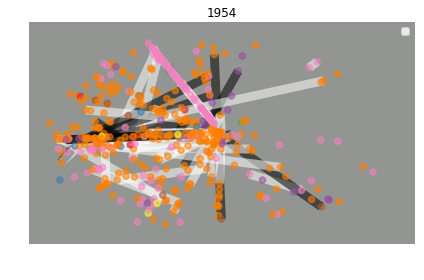

No handles with labels found to put in legend.


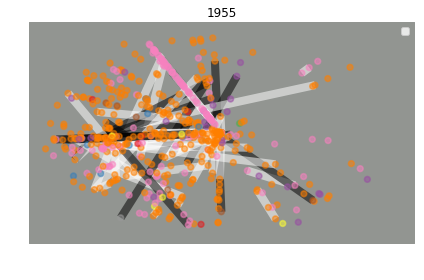

No handles with labels found to put in legend.


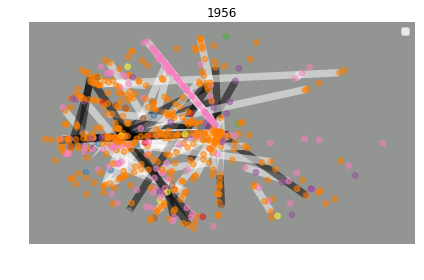

No handles with labels found to put in legend.


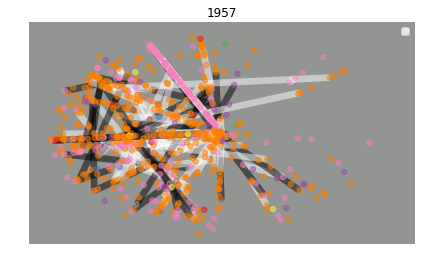

No handles with labels found to put in legend.


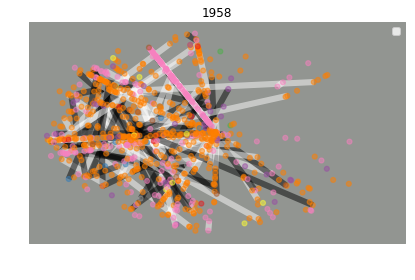

No handles with labels found to put in legend.


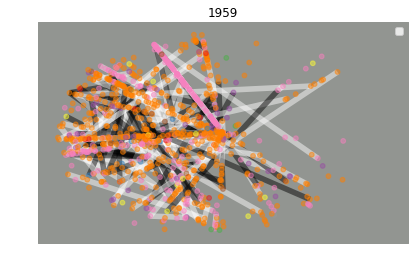

No handles with labels found to put in legend.


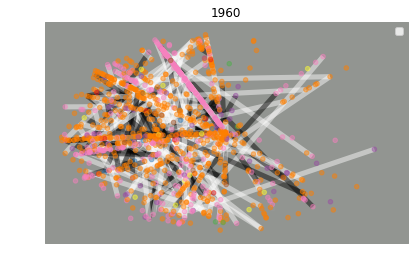

No handles with labels found to put in legend.


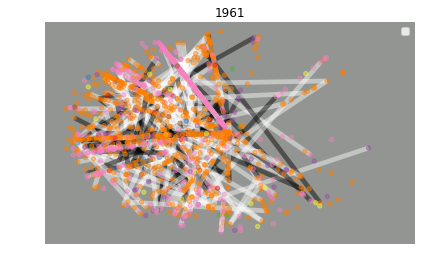

No handles with labels found to put in legend.


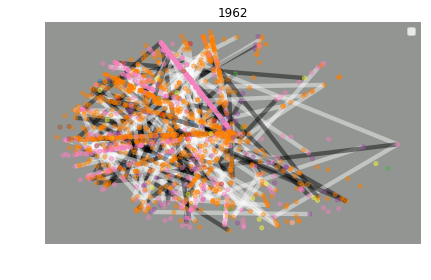

No handles with labels found to put in legend.


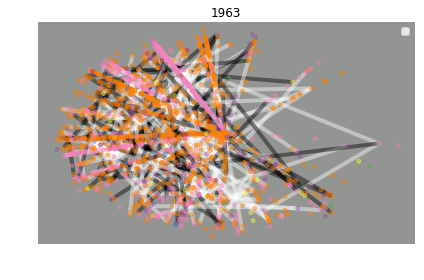

No handles with labels found to put in legend.


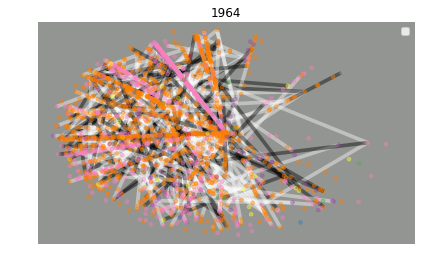

No handles with labels found to put in legend.


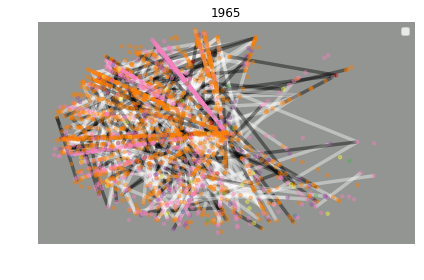

No handles with labels found to put in legend.


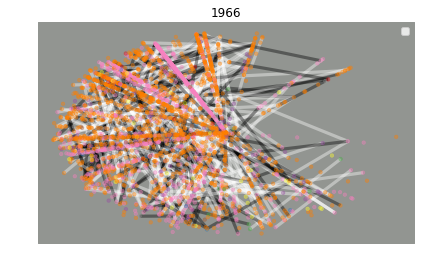

No handles with labels found to put in legend.


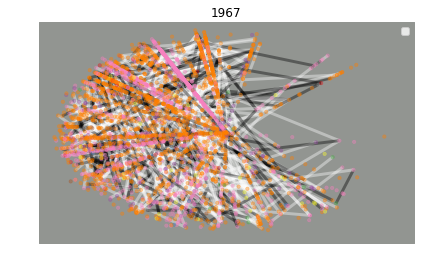

No handles with labels found to put in legend.


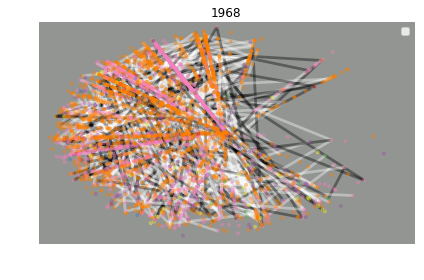

No handles with labels found to put in legend.


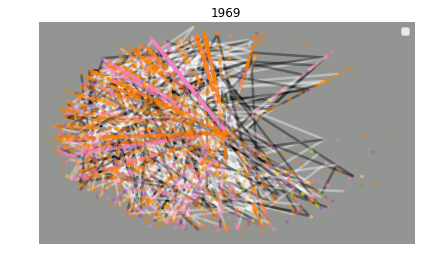

No handles with labels found to put in legend.


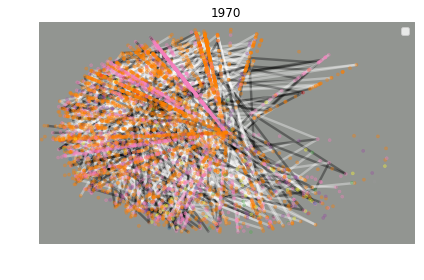

No handles with labels found to put in legend.


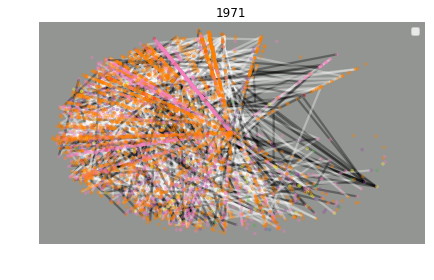

No handles with labels found to put in legend.


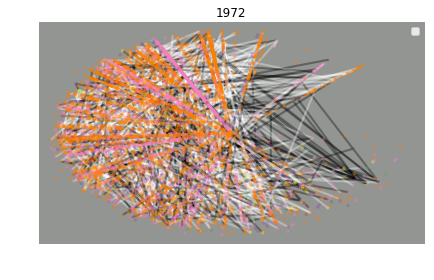

No handles with labels found to put in legend.


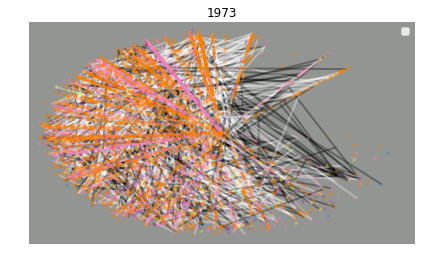

No handles with labels found to put in legend.


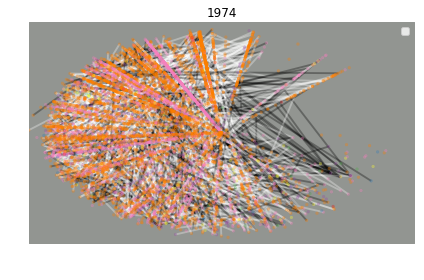

No handles with labels found to put in legend.


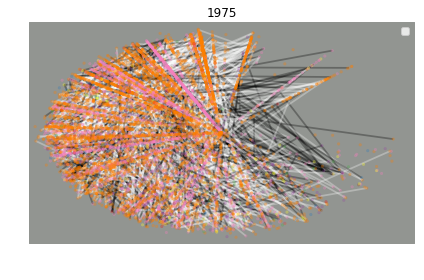

No handles with labels found to put in legend.


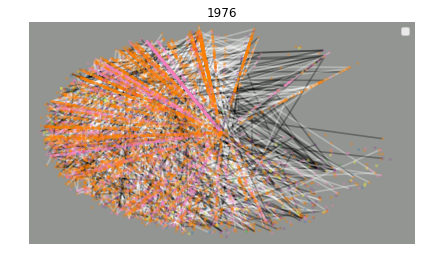

No handles with labels found to put in legend.


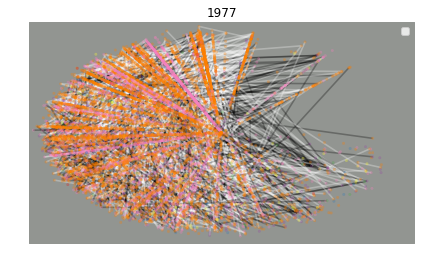

No handles with labels found to put in legend.


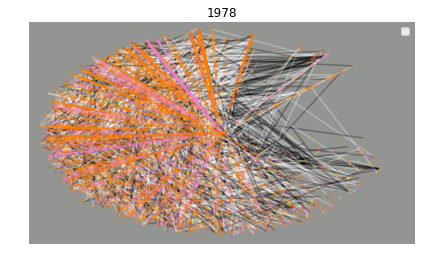

No handles with labels found to put in legend.


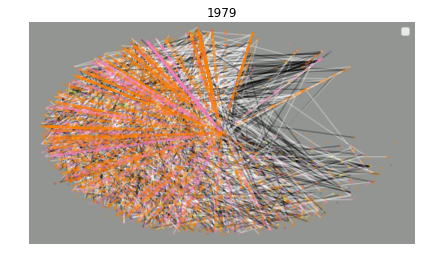

No handles with labels found to put in legend.


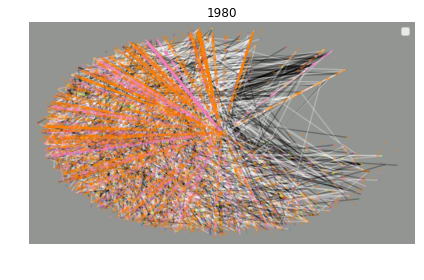

No handles with labels found to put in legend.


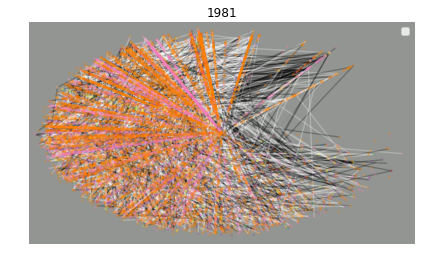

No handles with labels found to put in legend.


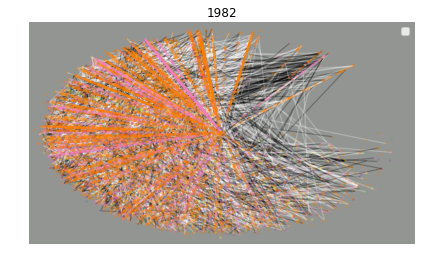

No handles with labels found to put in legend.


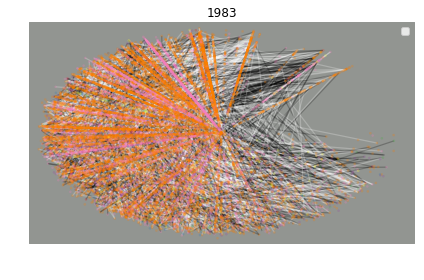

No handles with labels found to put in legend.


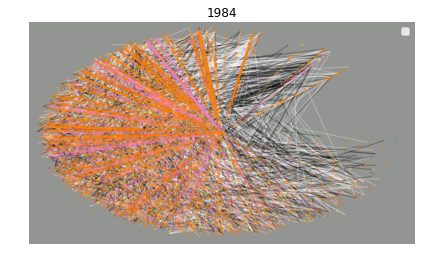

No handles with labels found to put in legend.


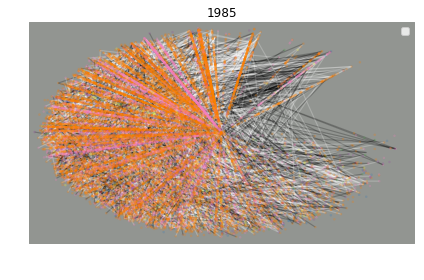

No handles with labels found to put in legend.


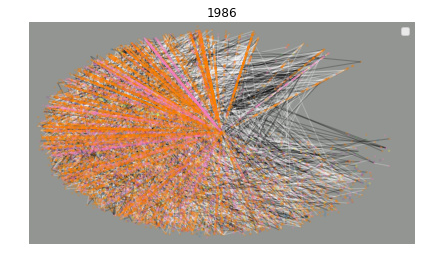

No handles with labels found to put in legend.


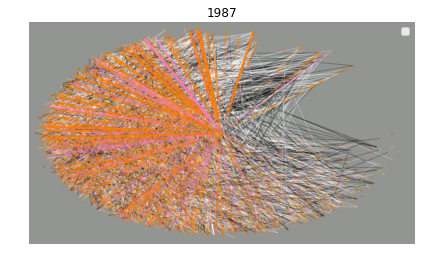

No handles with labels found to put in legend.


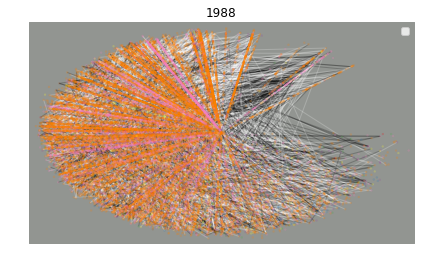

No handles with labels found to put in legend.


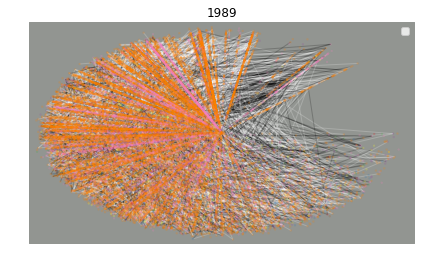

No handles with labels found to put in legend.


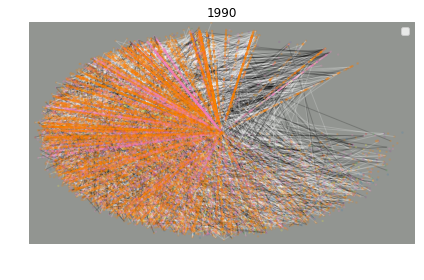

No handles with labels found to put in legend.


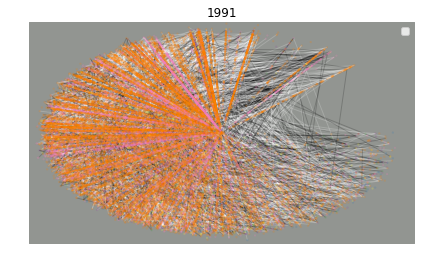

No handles with labels found to put in legend.


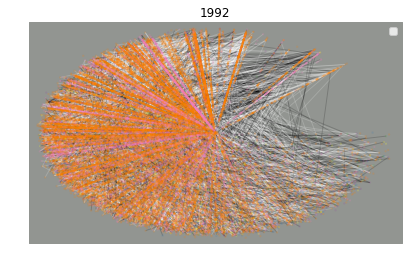

No handles with labels found to put in legend.


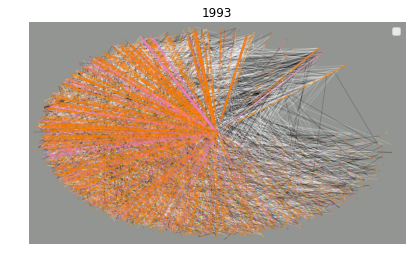

No handles with labels found to put in legend.


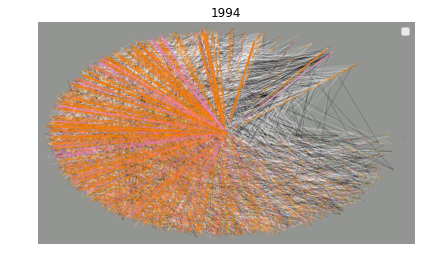

No handles with labels found to put in legend.


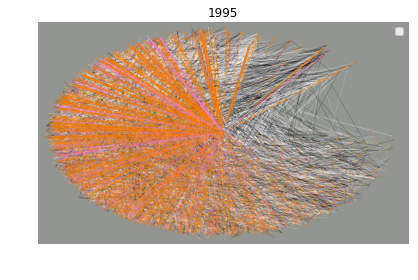

KeyboardInterrupt: 

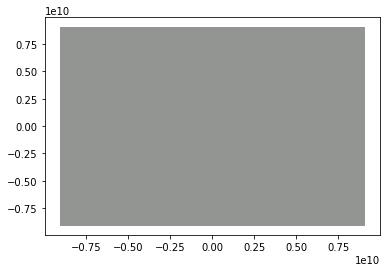

In [28]:
options = {
'node_size': 1,
'width': .05,
'alpha': .75,
'linewidths':.1
}
expo=4
images=[]
version=3_1
for i in range(1950,2019):
    options = {
    'node_size': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*2,
    'width': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*0.5,
    'alpha': 1-np.log(len(G_year[str(i)]))/(np.log(len(G_year['2018'])))*.95,
    'linewidths': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*.1}
    e_alpha = 1-np.log(len(G_year[str(i)]))/(np.log(len(G_year['2018'])))*.75
    graficar_red_options(Componente,G_year[str(i)],'campo',1,pos,[(-(i-1900 + 2)**5,(i-1900 + 2)**5),(-(i-1900 + 2)**5,(i-1900 + 2)**5)],str(i),options,e_alpha)
    images.append(imageio.imread(directorio+'fig'+str(i)+'.png'))
    images.append(imageio.imread(directorio+'fig'+str(i)+'.png'))
Final=50
for i in range(Final):
    images.append(imageio.imread(directorio+'fig'+str(2018)+'.png'))

imageio.mimsave(directorio+'Campos'+str(version)+'.gif', images)

In [24]:
import matplotlib.cm as cmx
import imageio
import random
def graficar_red_labels(G,G_year,atributo,ancho,pos,lims,year_year,options,e_alpha):
    
    Componente=G.copy()
    campos_list=[]
    val_map = {}
    val_map_year = {}
    campos_list_year=[]
    e_color=[]
    for edge in G_year.edges():
        if Componente.edges[edge]['inter']==0:
            e_color.append([0,0,0,e_alpha])
        else:
            e_color.append([1,1,1,e_alpha])
    ## Generas una lista de atributo de cada nodo
    for paper in Componente:
        campos_list.append(Componente.node[paper][atributo])
        val_map.update({paper: Componente.node[paper][atributo]})

    for paper in G_year:
        campos_list_year.append(G_year.node[paper][atributo])
        val_map_year.update({paper: G_year.node[paper][atributo]})
    
    grupo={}
    
    x={}
    sorted_by_value = []
    
    ## Asignamos los colores para cada valor de atributo, distinguiendo el año de cualquier otro atributo
    if atributo == 'year':
        y={}
        x=frequency(campos_list)
        
        for line in x.keys():
            y[line]=line
        sorted_by_value = sorted(y.items(), key=lambda kv: kv[1],reverse=True)
    else:   
        x=frequency(campos_list)
        sorted_by_value = sorted(x.items(), key=lambda kv: kv[1],reverse=True)
    
    random.seed(100)
    random.shuffle(sorted_by_value)
    
    cmap =[]
    cmap = cmx.Set1(np.linspace(0.0, 1.0, len(sorted_by_value)))
 
    ## A cada valor de atributo se le asigna un determinado color
    conversion={}
    for i in range(len(sorted_by_value)):
        conversion.update({sorted_by_value[i][0]: cmap[i]})
  

    ## Asigna un color a cada uno de los nodos de la red G_year (será el mismo para todos)
    color_map =[]  

    for paper in campos_list_year:
        color_map.append(conversion[paper])
    
    # Using a figure to use it as a parameter when calling nx.draw_networkx
    f = plt.figure(1)
    ax = f.add_subplot(1,1,1)

    nx.draw_networkx(G_year,pos=pos, node_color=color_map,edge_color=e_color,with_labels=False,ax=ax, **options)
    for revista in orden_revistas.keys():
        if lista_revista[revista]>len(lista_revista)*10**-1.35:
            tita=(orden_revistas[revista]/len(lista_revista))**(0.25)*2*np.pi
            r=(2018-1900)**5
            x=r*np.cos(tita)
            y=r*np.sin(tita)
            trans_angle = plt.gca().transData.transform_angles(np.array((tita/(2*np.pi)*360,)),np.array((x,y)).reshape((1, 2)))[0]
            plt.text(x,y, revista, rotation=trans_angle,size=10,rotation_mode='anchor')
#     for campo in lista_campo:
#         ax.plot(lims[0][1],lims[1][1],color=conversion[label],label=label,linestyle='',marker='.')
#         ax.legend(loc="lower right", bbox_to_anchor=(0.6,0.5))
    
    
    # Setting it to how it was looking before.                                                                                                              
    plt.axis('off')
    f.set_facecolor('grey')
    plt.legend(numpoints = 1)
    f.tight_layout()
    plt.xlim(lims[0])
    plt.ylim(lims[1])
    plt.savefig(directorio+'fig_label'+year_year+'.png')
    plt.show()

No handles with labels found to put in legend.


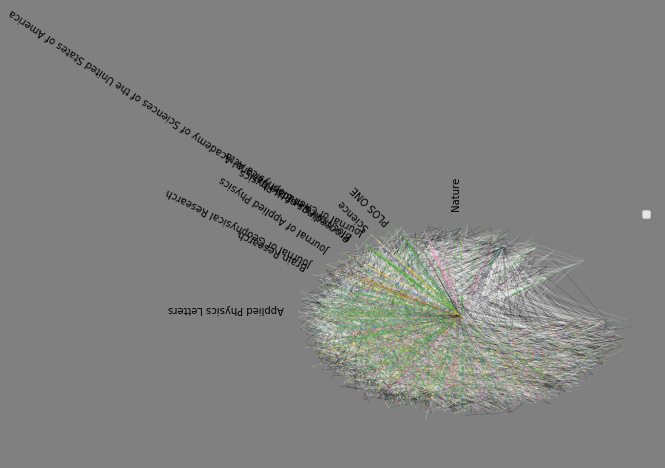

<Figure size 432x288 with 0 Axes>

In [139]:
i = 2018
options = {
'node_size': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*2,
'width': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*0.5,
'alpha': 1-np.log(len(G_year[str(i)]))/(np.log(len(G_year['2018'])))*.75,
'linewidths': (np.log(len(G_year['2018']))/np.log(len(G_year[str(i)])))**expo*.1}
e_alpha = 1-np.log(len(G_year[str(i)]))/(np.log(len(G_year['2018'])))*.75
graficar_red_labels(Componente,G_year[str(i)],'campo',1,pos,[(-(i-1900 + 2)**5,(i-1900 + 2)**5),(-(i-1900 + 2)**5,(i-1900 + 2)**5)],str(i),options,e_alpha)

plt.savefig(directorio+'fig'+str(version)+'.png')